In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('../'))
from src.hopsworks_connections import pull_data, upload_data
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np

# Print the current working directory
current_working_directory = os.getcwd()
print("Current Working Directory:", current_working_directory)

/Users/davydsadovskyy/GitBackedShit/crypto-prediction/venv_crypto_prediction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current Working Directory: /Users/davydsadovskyy/GitBackedShit/crypto-prediction/notebooks


### Historical OHLC (open, high, low close) data was downloaded as a .csv from here https://www.coinlore.com/coin/ethereum/historical-data

### Get a dataframe of our already manually downloaded, raw Ethereum OHLC data

In [2]:
eth_ohlc_raw = pd.read_csv('../data/raw/ohlc/ethereum.csv', parse_dates=True)
eth_ohlc_raw

,Date,Open,High,Low,Close,Volume,Volume(ETH),Market Cap
0,05/12/2024,$2912,$2951,$2906,$2931,$5.2 bn,1779026.0,$358.1 bn
1,05/11/2024,$2909,$2935,$2894,$2911,$5.9 bn,2033385.0,$356.9 bn
2,05/10/2024,$3035,$3050,$2889,$2910,$10.6 bn,3557434.0,$365 bn
3,05/09/2024,$2977,$3055,$2958,$3036,$9.6 bn,3190231.0,$367 bn
4,05/08/2024,$3013,$3036,$2944,$2975,$10.2 bn,3400618.0,$367.5 bn
...,...,...,...,...,...,...,...,...
3178,08/11/2015,$0.7081,$1.13,$0.6632,$1.07,$1.5 m,1638721.0,$53.9 m
3179,08/10/2015,$0.7140,$0.7299,$0.6365,$0.7084,$405.3 K,581293.0,$42.1 m
3180,08/09/2015,$0.7061,$0.8798,$0.6292,$0.7019,$532.2 K,729741.0,$44.1 m
3181,08/08/2015,$2.79,$2.80,$0.7147,$0.7533,$674.2 K,382082.0,$106.5 m


### Clean the raw data a bit

In [3]:
def convert_value(value):
    """
    Converts a string value to a float. Removes $ signs, and converts
    billion (bn), million (m), and thousand (K) values to their numeric equivalents.
    """
    value = value.replace('$', '')  # Remove $ sign to simplify processing
    if value[-1].lower() == 'm':
        return float(value[:-1]) * 1_000_000
    elif value[-1].lower() == 'b':
        return float(value[:-1]) * 1_000_000_000
    elif value[-1].lower() == 'k':
        return float(value[:-1]) * 1_000
    elif value[-2:].lower() == 'bn':  # Handle 'bn' for billions
        return float(value[:-2]) * 1_000_000_000
    else:
        return float(value)

eth_ohlc_raw.columns = [col.lower() for col in eth_ohlc_raw.columns]
eth_ohlc_raw.rename(columns={'volume(eth)': 'volume_eth', 'market cap': 'market_cap'}, inplace=True)

for col in ['open', 'high', 'low', 'close', 'volume', 'market_cap']:
    eth_ohlc_raw[col] = eth_ohlc_raw[col].apply(convert_value)

eth_ohlc_raw['date'] = pd.to_datetime(eth_ohlc_raw['date'])

eth_ohlc_raw

,date,open,high,low,close,volume,volume_eth,market_cap
0,2024-05-12,2912.0000,2951.0000,2906.0000,2931.0000,5.200000e+09,1779026.0,3.581000e+11
1,2024-05-11,2909.0000,2935.0000,2894.0000,2911.0000,5.900000e+09,2033385.0,3.569000e+11
2,2024-05-10,3035.0000,3050.0000,2889.0000,2910.0000,1.060000e+10,3557434.0,3.650000e+11
3,2024-05-09,2977.0000,3055.0000,2958.0000,3036.0000,9.600000e+09,3190231.0,3.670000e+11
4,2024-05-08,3013.0000,3036.0000,2944.0000,2975.0000,1.020000e+10,3400618.0,3.675000e+11
...,...,...,...,...,...,...,...,...
3178,2015-08-11,0.7081,1.1300,0.6632,1.0700,1.500000e+06,1638721.0,5.390000e+07
3179,2015-08-10,0.7140,0.7299,0.6365,0.7084,4.053000e+05,581293.0,4.210000e+07
3180,2015-08-09,0.7061,0.8798,0.6292,0.7019,5.322000e+05,729741.0,4.410000e+07
3181,2015-08-08,2.7900,2.8000,0.7147,0.7533,6.742000e+05,382082.0,1.065000e+08


## Create response variables. There will be a separate model for each eventually.

### These are binary response variables with a value of 1 if the specificied percent increase occurs between the current day's close and tomorrow's average between close and high value. They have a value of 0 if this percent increase isn't reached. When trading, it is safer to use this average than the high value because there is a higher chance that a limit order won't reach the high value.

In [4]:
transformed_df = eth_ohlc_raw.copy()
transformed_df = transformed_df.iloc[::-1].reset_index(drop=True) # reverse order

In [5]:
# transformed_df["tmw_avg_high_close"] 
tmw_avg_high_close = (transformed_df["high"].shift(-1) + transformed_df["close"].shift(-1)) / 2
transformed_df['tmw_percent_increase_to_avg_high_low'] = ((tmw_avg_high_close - transformed_df['close']) / transformed_df['close'])

### Examine distributions of response variables

Distribution of % return from a day's close to the next day's (high+close)/2

Minimum: -0.3586101083032492
25th percentile: -0.005340348030929072
Median: 0.008627796880003074
75th percentile): 0.03399874966326406
Maximum: 0.5573770491803278


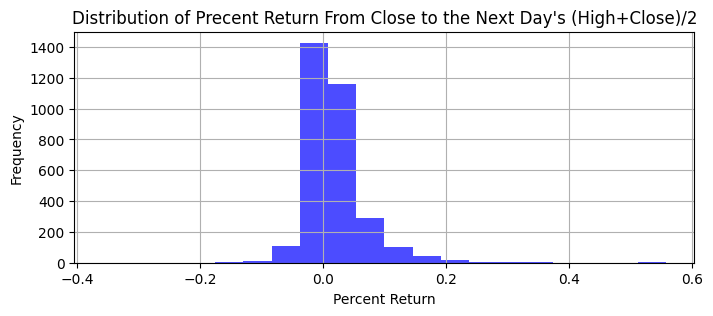

In [6]:
tmw_percent_return = transformed_df['tmw_percent_increase_to_avg_high_low']
print("Distribution of % return from a day's close to the next day's (high+close)/2")
print("\nMinimum:", tmw_percent_return.min())
print("25th percentile:", tmw_percent_return.quantile(0.25))
print("Median:", tmw_percent_return.quantile(0.50))
print("75th percentile):", tmw_percent_return.quantile(0.75))
print("Maximum:", tmw_percent_return.max())

plt.figure(figsize=(8, 3))
plt.hist(tmw_percent_return, bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Precent Return From Close to the Next Day's (High+Close)/2")
plt.xlabel('Percent Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Create binary response variables that will be used in the models

In [7]:
# Create binary variables for specific percent increases: 
# intervals = [i for i in range(1, 6)] # 1 - 5
intervals = [0 + 0.25 * i for i in range(int((3.25) / 0.25))] # 0 - 3 by .25
for i in intervals:
    threshold = i / 100
    increase_column_name = f"tmw_{str(i).replace('.', '_')}_percent_increase_binary"
    transformed_df[increase_column_name] = (transformed_df['tmw_percent_increase_to_avg_high_low'] >= threshold).astype(int)

# Create binary variables for specific percent decreases
intervals = [0.25 + 0.25 * i for i in range(int((1) / 0.25))] # .25 - 1 by .25
for i in intervals:
    threshold = i / 100
    decrease_column_name = f"tmw_{str(i).replace('.', '_')}_percent_decrease_binary"
    transformed_df[decrease_column_name] = (transformed_df['tmw_percent_increase_to_avg_high_low'] <= threshold *-1).astype(int)

In [8]:
print(transformed_df['tmw_0_0_percent_increase_binary'].value_counts(normalize=True))
transformed_df['tmw_0_0_percent_increase_binary'].value_counts()

tmw_0_0_percent_increase_binary
1    0.653157
0    0.346843
Name: proportion, dtype: float64


tmw_0_0_percent_increase_binary
1    2079
0    1104
Name: count, dtype: int64

In [9]:
print(transformed_df['tmw_1_0_percent_increase_binary'].value_counts(normalize=True))
transformed_df['tmw_1_0_percent_increase_binary'].value_counts()

tmw_1_0_percent_increase_binary
0    0.517751
1    0.482249
Name: proportion, dtype: float64


tmw_1_0_percent_increase_binary
0    1648
1    1535
Name: count, dtype: int64

In [10]:
# Last row doesn't have a value for tomorrow's return, but it was assigned 0's for response variable. Convert them to NA

columns = []
intervals = [0 + 0.25 * i for i in range(int((3.25) / 0.25))] # 0 - 3 by .25
for i in intervals:
    increase_column_name = f"tmw_{str(i).replace('.', '_')}_percent_increase_binary"
    columns.append(increase_column_name)

intervals = [0.25 + 0.25 * i for i in range(int((1) / 0.25))] # .25 - 1 by .25
for i in intervals:
    decrease_column_name = f"tmw_{str(i).replace('.', '_')}_percent_decrease_binary"
    columns.append(decrease_column_name)

# Set the last row's specified columns to NaN
transformed_df.loc[transformed_df.index[-1], columns] = pd.NA

In [11]:
transformed_df

,date,open,high,low,close,volume,volume_eth,market_cap,tmw_percent_increase_to_avg_high_low,tmw_0_0_percent_increase_binary,...,tmw_1_75_percent_increase_binary,tmw_2_0_percent_increase_binary,tmw_2_25_percent_increase_binary,tmw_2_5_percent_increase_binary,tmw_2_75_percent_increase_binary,tmw_3_0_percent_increase_binary,tmw_0_25_percent_decrease_binary,tmw_0_5_percent_decrease_binary,tmw_0_75_percent_decrease_binary,tmw_1_0_percent_decrease_binary
0,2015-08-07,2.8300,3.5400,2.5200,2.7700,1.643000e+05,56374.0,1.753000e+08,-0.358610,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,2015-08-08,2.7900,2.8000,0.7147,0.7533,6.742000e+05,382082.0,1.065000e+08,0.049847,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,2015-08-09,0.7061,0.8798,0.6292,0.7019,5.322000e+05,729741.0,4.410000e+07,0.024576,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-08-10,0.7140,0.7299,0.6365,0.7084,4.053000e+05,581293.0,4.210000e+07,0.552795,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,2015-08-11,0.7081,1.1300,0.6632,1.0700,1.500000e+06,1638721.0,5.390000e+07,0.172897,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178,2024-05-08,3013.0000,3036.0000,2944.0000,2975.0000,1.020000e+10,3400618.0,3.675000e+11,0.023697,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3179,2024-05-09,2977.0000,3055.0000,2958.0000,3036.0000,9.600000e+09,3190231.0,3.670000e+11,-0.018445,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3180,2024-05-10,3035.0000,3050.0000,2889.0000,2910.0000,1.060000e+10,3557434.0,3.650000e+11,0.004467,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3181,2024-05-11,2909.0000,2935.0000,2894.0000,2911.0000,5.900000e+09,2033385.0,3.569000e+11,0.010306,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create Predictor Variables

### Examine distributions of certain transformed features, to create teh best thresholds for binary predictors

In [12]:
transformed_df['perc_from_low_to_high'] = (transformed_df['high'] - transformed_df['low']) / transformed_df['low']
perc_from_low_to_high = transformed_df['perc_from_low_to_high']

tmw_vol = transformed_df["volume"].shift(-1)
tmw_perc_change_vol = (tmw_vol - transformed_df['volume']) / transformed_df['volume']

perc_change_price = transformed_df['tmw_percent_increase_to_avg_high_low']

statistics = {
    'Metric': ['Minimum', '5th percentile', '10th percentile', '20th percentile', '30th percentile',
               '40th percentile', '50th percentile', '60th percentile', '70th percentile', '80th percentile',
               '90th percentile', '95th percentile', 'Maximum'],
    'Low to High Percent Spread': [
        perc_from_low_to_high.min(),
        perc_from_low_to_high.quantile(0.05),
        perc_from_low_to_high.quantile(0.10),
        perc_from_low_to_high.quantile(0.20),
        perc_from_low_to_high.quantile(0.30),
        perc_from_low_to_high.quantile(0.40),
        perc_from_low_to_high.quantile(0.50),
        perc_from_low_to_high.quantile(0.60),
        perc_from_low_to_high.quantile(0.70),
        perc_from_low_to_high.quantile(0.80),
        perc_from_low_to_high.quantile(0.90),
        perc_from_low_to_high.quantile(0.95),
        perc_from_low_to_high.max()
    ],
    'Change from Today Vol to Tomorrow Vol': [
        tmw_perc_change_vol.min(),
        tmw_perc_change_vol.quantile(0.05),
        tmw_perc_change_vol.quantile(0.10),
        tmw_perc_change_vol.quantile(0.20),
        tmw_perc_change_vol.quantile(0.30),
        tmw_perc_change_vol.quantile(0.40),
        tmw_perc_change_vol.quantile(0.50),
        tmw_perc_change_vol.quantile(0.60),
        tmw_perc_change_vol.quantile(0.70),
        tmw_perc_change_vol.quantile(0.80),
        tmw_perc_change_vol.quantile(0.90),
        tmw_perc_change_vol.quantile(0.95),
        tmw_perc_change_vol.max()
    ],
    'Change from Today Close to Tomorrow Avg': [
        perc_change_price.min(),
        perc_change_price.quantile(0.05),
        perc_change_price.quantile(0.10),
        perc_change_price.quantile(0.20),
        perc_change_price.quantile(0.30),
        perc_change_price.quantile(0.40),
        perc_change_price.quantile(0.50),
        perc_change_price.quantile(0.60),
        perc_change_price.quantile(0.70),
        perc_change_price.quantile(0.80),
        perc_change_price.quantile(0.90),
        perc_change_price.quantile(0.95),
        perc_change_price.max()
    ]
}

df_statistics = pd.DataFrame(statistics)
df_statistics

,Metric,Low to High Percent Spread,Change from Today Vol to Tomorrow Vol,Change from Today Close to Tomorrow Avg
0,Minimum,0.003252,-15.319210,-0.358610
1,5th percentile,0.016415,-0.468895,-0.033844
2,10th percentile,0.021300,-0.349036,-0.020408
3,20th percentile,0.029311,-0.214209,-0.008802
4,30th percentile,0.036435,-0.133333,-0.002487
5,40th percentile,0.043525,-0.069253,0.002665
6,50th percentile,0.053001,-0.008231,0.008628
7,60th percentile,0.063890,0.060922,0.016360
8,70th percentile,0.077456,0.137346,0.026272
9,80th percentile,0.097568,0.275955,0.041614


### Create various predictor variables based on price/volume trends, and on seasonality

In [13]:
def add_predictors(data):
    df = data.copy()

    # Create binary columns for each month (1-12)
    month_names = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
    for i in range(1, 13):  # Months are typically 1-12
        month_name = month_names[i-1]  # Get the month name from the list
        df[f'{month_name}'] = (df['date'].dt.month == i).astype(int)

    # Create binary columns for each day
    days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    for i, day in enumerate(days):
        df[f'{day.lower()}'] = (df['date'].dt.dayofweek == i).astype(int)

    horizons = [2,5,10,25,50,100] 
    for horizon in horizons:

        # Ratio - Close Price Simple Moving Average (SMA)
        sma_col = f"sma_{horizon}"
        df[sma_col] = df["close"] / ta.sma(df["close"], length=horizon)
        # Close Price Relative Strength Index (RSI)
        rsi_col = f"rsi_{horizon}"
        df[rsi_col] = ta.rsi(df["close"], length=horizon)

        # Ratio - Volume Simple Moving Average (SMA)
        sma_col = f"volume_sma_{horizon}"
        df[sma_col] = df["volume"] / ta.sma(df["volume"], length=horizon)
        # Volume Relative Strength Index (RSI)
        rsi_col = f"volume_rsi_{horizon}"
        df[rsi_col] = ta.rsi(df["volume"], length=horizon)

        # Ratio - High-Low Spread Simple Moving Average (SMA)
        sma_col = f"spread_sma_{horizon}"
        df[sma_col] = df["perc_from_low_to_high"] / ta.sma(df["perc_from_low_to_high"], length=horizon)
        # High-Low Spread Relative Strength Index (RSI)
        rsi_col = f"spread_rsi_{horizon}"
        df[rsi_col] = ta.rsi(df["perc_from_low_to_high"], length=horizon)

        # Sum of the number of days in the past horizon that had a certain percent change in price from a day's close to the next day's (high+close)/2
        df[f"last_{horizon}_day_40th_to_50th_pct_price_change_count"] = ((df['tmw_percent_increase_to_avg_high_low'] > 0.002684) & (df['tmw_percent_increase_to_avg_high_low'] <= 0.008635)).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_50th_to_60th_pct_price_change_count"] = ((df['tmw_percent_increase_to_avg_high_low'] > 0.008635) & (df['tmw_percent_increase_to_avg_high_low'] <= 0.016393)).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_60th_to_70th_pct_price_change_count"] = ((df['tmw_percent_increase_to_avg_high_low'] > 0.016393) & (df['tmw_percent_increase_to_avg_high_low'] <= 0.026398)).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_70th_to_80th_pct_price_change_count"] = ((df['tmw_percent_increase_to_avg_high_low'] > 0.026398) & (df['tmw_percent_increase_to_avg_high_low'] <= 0.041709)).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_80th_to_90th_pct_price_change_count"] = ((df['tmw_percent_increase_to_avg_high_low'] > 0.041709) & (df['tmw_percent_increase_to_avg_high_low'] <= 0.070177)).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_90th_to_95th_pct_price_change_count"] = ((df['tmw_percent_increase_to_avg_high_low'] > 0.070177) & (df['tmw_percent_increase_to_avg_high_low'] <= 0.106177)).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_40th_pct_price_change_count"] = (df['tmw_percent_increase_to_avg_high_low'] > 0.002684).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_50th_pct_price_change_count"] = (df['tmw_percent_increase_to_avg_high_low'] > 0.008635).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_60th_pct_price_change_count"] = (df['tmw_percent_increase_to_avg_high_low'] > 0.016393).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_70th_pct_price_change_count"] = (df['tmw_percent_increase_to_avg_high_low'] > 0.026398).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_80th_pct_price_change_count"] = (df['tmw_percent_increase_to_avg_high_low'] > 0.041709).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_90th_pct_price_change_count"] = (df['tmw_percent_increase_to_avg_high_low'] > 0.070177).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_95th_pct_price_change_count"] = (df['tmw_percent_increase_to_avg_high_low'] > 0.106177).astype(int).shift(1).rolling(horizon).sum()
                
        
        # Sum of the number of days in the past horizon that had a certain percent chamge in volume from one day to the next
        tmw_vol = df["volume"].shift(-1)
        tmw_perc_change_vol = (tmw_vol - df['volume']) / df['volume']
        df[f"last_{horizon}_day_40th_to_50th_pct_volume_change_count"] = ((tmw_perc_change_vol > -0.069444) & (tmw_perc_change_vol <= -0.008197)).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_50th_to_60th_pct_volume_change_count"] = ((tmw_perc_change_vol > -0.008197) & (tmw_perc_change_vol <= 0.061069)).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_60th_to_70th_pct_volume_change_count"] = ((tmw_perc_change_vol > 0.061069) & (tmw_perc_change_vol <= 0.137500)).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_70th_to_80th_pct_volume_change_count"] = ((tmw_perc_change_vol > 0.137500) & (tmw_perc_change_vol <= 0.276316)).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_80th_to_90th_pct_volume_change_count"] = ((tmw_perc_change_vol > 0.276316) & (tmw_perc_change_vol <= 0.544118)).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_90th_to_95th_pct_volume_change_count"] = ((tmw_perc_change_vol > 0.544118) & (tmw_perc_change_vol <= 0.885965)).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_40th_pct_volume_change_count"] = (tmw_perc_change_vol > -0.069444).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_50th_pct_volume_change_count"] = (tmw_perc_change_vol > -0.008197).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_60th_pct_volume_change_count"] = (tmw_perc_change_vol > 0.061069).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_70th_pct_volume_change_count"] = (tmw_perc_change_vol > 0.137500).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_80th_pct_volume_change_count"] = (tmw_perc_change_vol > 0.276316).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_90th_pct_volume_change_count"] = (tmw_perc_change_vol > 0.544118).astype(int).shift(1).rolling(horizon).sum()
        df[f"last_{horizon}_day_95th_pct_volume_change_count"] = (tmw_perc_change_vol > 0.885965).astype(int).shift(1).rolling(horizon).sum()

        # Sum of the number of days in the past horizon that had a certain percent chamge in the difference between low and high price
        prc_from_low_to_high = (df['high'] - df['low']) / df['low']
        df[f"last_{horizon}_day_40th_to_50th_pct_spread_count"] = ((prc_from_low_to_high > 0.043674) & (prc_from_low_to_high <= 0.053125)).astype(int).rolling(horizon).sum()
        df[f"last_{horizon}_day_50th_to_60th_pct_spread_count"] = ((prc_from_low_to_high > 0.053125) & (prc_from_low_to_high <= 0.064163)).astype(int).rolling(horizon).sum()
        df[f"last_{horizon}_day_60th_to_70th_pct_spread_count"] = ((prc_from_low_to_high > 0.064163) & (prc_from_low_to_high <= 0.077524)).astype(int).rolling(horizon).sum()
        df[f"last_{horizon}_day_70th_to_80th_pct_spread_count"] = ((prc_from_low_to_high > 0.077524) & (prc_from_low_to_high <= 0.097901)).astype(int).rolling(horizon).sum()
        df[f"last_{horizon}_day_80th_to_90th_pct_spread_count"] = ((prc_from_low_to_high > 0.097901) & (prc_from_low_to_high <= 0.137338)).astype(int).rolling(horizon).sum()
        df[f"last_{horizon}_day_90th_to_95th_pct_spread_count"] = ((prc_from_low_to_high > 0.137338) & (prc_from_low_to_high <= 0.191936)).astype(int).rolling(horizon).sum()
        df[f"last_{horizon}_day_40th_pct_spread_count"] = (prc_from_low_to_high > 0.043674).astype(int).rolling(horizon).sum()
        df[f"last_{horizon}_day_50th_pct_spread_count"] = (prc_from_low_to_high > 0.053125).astype(int).rolling(horizon).sum()
        df[f"last_{horizon}_day_60th_pct_spread_count"] = (prc_from_low_to_high > 0.064163).astype(int).rolling(horizon).sum()
        df[f"last_{horizon}_day_70th_pct_spread_count"] = (prc_from_low_to_high > 0.077524).astype(int).rolling(horizon).sum()
        df[f"last_{horizon}_day_80th_pct_spread_count"] = (prc_from_low_to_high > 0.097901).astype(int).rolling(horizon).sum()
        df[f"last_{horizon}_day_90th_pct_spread_count"] = (prc_from_low_to_high > 0.137338).astype(int).rolling(horizon).sum()
        df[f"last_{horizon}_day_95th_pct_spread_count"] = (prc_from_low_to_high > 0.191936).astype(int).rolling(horizon).sum()

    return df

In [14]:
df_predictors_responses = add_predictors(transformed_df)

In [15]:
df_predictors_responses

,date,open,high,low,close,volume,volume_eth,market_cap,tmw_percent_increase_to_avg_high_low,tmw_0_0_percent_increase_binary,...,last_100_day_70th_to_80th_pct_spread_count,last_100_day_80th_to_90th_pct_spread_count,last_100_day_90th_to_95th_pct_spread_count,last_100_day_40th_pct_spread_count,last_100_day_50th_pct_spread_count,last_100_day_60th_pct_spread_count,last_100_day_70th_pct_spread_count,last_100_day_80th_pct_spread_count,last_100_day_90th_pct_spread_count,last_100_day_95th_pct_spread_count
0,2015-08-07,2.8300,3.5400,2.5200,2.7700,1.643000e+05,56374.0,1.753000e+08,-0.358610,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-08-08,2.7900,2.8000,0.7147,0.7533,6.742000e+05,382082.0,1.065000e+08,0.049847,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-08-09,0.7061,0.8798,0.6292,0.7019,5.322000e+05,729741.0,4.410000e+07,0.024576,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-08-10,0.7140,0.7299,0.6365,0.7084,4.053000e+05,581293.0,4.210000e+07,0.552795,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-08-11,0.7081,1.1300,0.6632,1.0700,1.500000e+06,1638721.0,5.390000e+07,0.172897,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178,2024-05-08,3013.0000,3036.0000,2944.0000,2975.0000,1.020000e+10,3400618.0,3.675000e+11,0.023697,1.0,...,8.0,4.0,3.0,47.0,33.0,25.0,15.0,7.0,3.0,0.0
3179,2024-05-09,2977.0000,3055.0000,2958.0000,3036.0000,9.600000e+09,3190231.0,3.670000e+11,-0.018445,0.0,...,8.0,4.0,3.0,47.0,33.0,25.0,15.0,7.0,3.0,0.0
3180,2024-05-10,3035.0000,3050.0000,2889.0000,2910.0000,1.060000e+10,3557434.0,3.650000e+11,0.004467,1.0,...,8.0,4.0,3.0,48.0,34.0,25.0,15.0,7.0,3.0,0.0
3181,2024-05-11,2909.0000,2935.0000,2894.0000,2911.0000,5.900000e+09,2033385.0,3.569000e+11,0.010306,1.0,...,8.0,4.0,3.0,48.0,34.0,25.0,15.0,7.0,3.0,0.0


### Remove NA rows

In [16]:
# Dropping all rows with NA, expect the last row
last_row = df_predictors_responses.iloc[[-1]]
df_predictors_responses = df_predictors_responses.dropna()
df_predictors_responses = pd.concat([df_predictors_responses, last_row])

df_predictors_responses

,date,open,high,low,close,volume,volume_eth,market_cap,tmw_percent_increase_to_avg_high_low,tmw_0_0_percent_increase_binary,...,last_100_day_70th_to_80th_pct_spread_count,last_100_day_80th_to_90th_pct_spread_count,last_100_day_90th_to_95th_pct_spread_count,last_100_day_40th_pct_spread_count,last_100_day_50th_pct_spread_count,last_100_day_60th_pct_spread_count,last_100_day_70th_pct_spread_count,last_100_day_80th_pct_spread_count,last_100_day_90th_pct_spread_count,last_100_day_95th_pct_spread_count
100,2015-11-15,0.8912,0.9215,0.8750,0.9064,4.118000e+05,458365.0,6.720000e+07,0.033594,1.0,...,18.0,9.0,18.0,94.0,86.0,79.0,73.0,55.0,46.0,28.0
101,2015-11-16,0.9062,0.9447,0.8920,0.9290,6.209000e+05,676442.0,6.860000e+07,0.097955,1.0,...,18.0,9.0,18.0,94.0,86.0,78.0,72.0,54.0,45.0,27.0
102,2015-11-17,0.9249,1.0300,0.9058,1.0100,1.100000e+06,1183690.0,7.220000e+07,-0.009901,0.0,...,18.0,10.0,18.0,94.0,86.0,78.0,72.0,54.0,44.0,26.0
103,2015-11-18,0.9900,1.0100,0.9405,0.9900,6.811000e+05,691994.0,7.360000e+07,-0.007323,0.0,...,18.0,10.0,17.0,94.0,86.0,78.0,71.0,53.0,43.0,26.0
104,2015-11-19,0.9887,1.0100,0.9375,0.9555,4.435000e+05,455866.0,7.280000e+07,-0.015908,0.0,...,18.0,10.0,17.0,94.0,86.0,78.0,70.0,52.0,42.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178,2024-05-08,3013.0000,3036.0000,2944.0000,2975.0000,1.020000e+10,3400618.0,3.675000e+11,0.023697,1.0,...,8.0,4.0,3.0,47.0,33.0,25.0,15.0,7.0,3.0,0.0
3179,2024-05-09,2977.0000,3055.0000,2958.0000,3036.0000,9.600000e+09,3190231.0,3.670000e+11,-0.018445,0.0,...,8.0,4.0,3.0,47.0,33.0,25.0,15.0,7.0,3.0,0.0
3180,2024-05-10,3035.0000,3050.0000,2889.0000,2910.0000,1.060000e+10,3557434.0,3.650000e+11,0.004467,1.0,...,8.0,4.0,3.0,48.0,34.0,25.0,15.0,7.0,3.0,0.0
3181,2024-05-11,2909.0000,2935.0000,2894.0000,2911.0000,5.900000e+09,2033385.0,3.569000e+11,0.010306,1.0,...,8.0,4.0,3.0,48.0,34.0,25.0,15.0,7.0,3.0,0.0


### Save to .csv

In [17]:
df_predictors_responses.to_csv('../data/transformed/ohlc/ethereum.csv', index=False)